In [31]:
import cv2
import os
from modules_segmentation import *
from mask_corners import gridcorners
import pandas as pd


In [32]:
image_folder = "/user/christoph.wald/u15287/big-scratch/02_splitted_data/train_labeled/images_uncropped"
image_files = os.listdir(image_folder)

#load mask
grown_mask = cv2.imread(
    "/user/christoph.wald/u15287/insect_pest_detection/2_4_image_processing/handcrafted_mask.jpg", 
    cv2.IMREAD_GRAYSCALE
)

In [33]:
image_file = image_files[1]
filename= image_file.split(".")[0]
filename

'BRAIIM_0003'

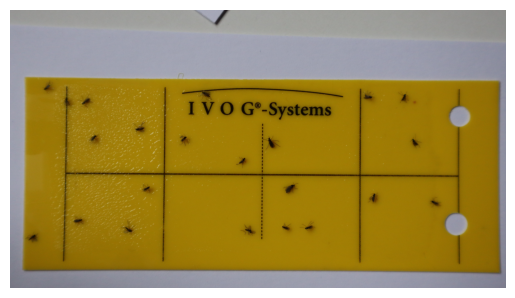

In [34]:
image = cv2.imread(os.path.join(image_folder, image_file))
show(image)

In [35]:
imageYST = find_contour(image)
imagecorners = find_corners(image, imageYST)
imagecorners = order_corners(imagecorners)

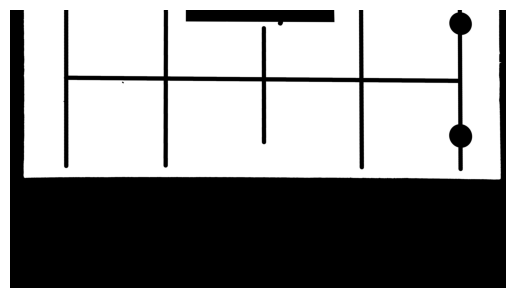

In [36]:
H, _ = cv2.findHomography(gridcorners, imagecorners, cv2.RANSAC)
mask_h = get_h_mid(cv2.warpPerspective(grown_mask, H, (image.shape[1], image.shape[0])))
image_h = get_h_mid(create_binary_mask(image))
dy = get_midpoint(image_h)- get_midpoint(mask_h)
# build combined transform
T = np.array([[1, 0, 0],
            [0, 1, dy],
            [0, 0, 1]], dtype=np.float32)
H_shifted = T @ H
mask = cv2.warpPerspective(grown_mask, H_shifted, (image.shape[1], image.shape[0]))
show(mask)

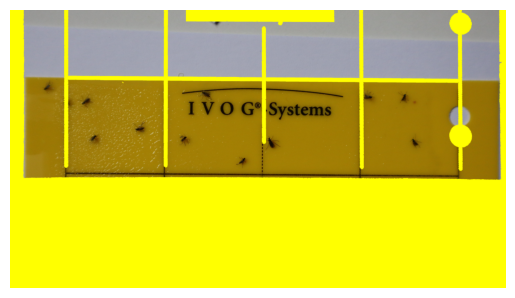

In [37]:
yellow_mask = mask == 0 #mask or shifted_mask
image_wo_grid = image.copy()
image_wo_grid[yellow_mask] = [0,255,255]
show(image_wo_grid)

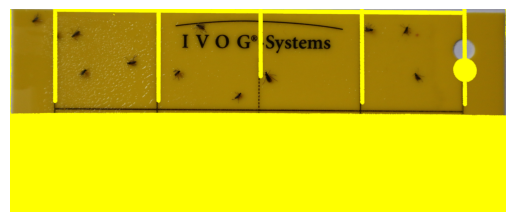

In [38]:
#crop the image
x, y, w, h = cv2.boundingRect(imageYST)
cropped_image_wo_grid = image_wo_grid[y:y+h, x:x+w]
show(cropped_image_wo_grid)

19 bounding boxes found.


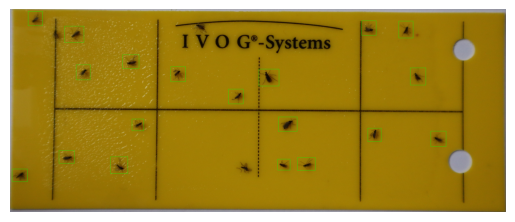

In [39]:
image_cropped = image[y:y+h, x:x+w]
#finding the rectangles given by the yolo labels
label_file = os.path.splitext(image_file)[0] + ".txt"
labels_path = "/user/christoph.wald/u15287/big-scratch/02_splitted_data/train_labeled/labels_uncropped"
label_path = os.path.join(labels_path, label_file)
with open(label_path, "r") as f:
    yolo_labels = f.read().splitlines()
yolo_rectangles = yolo_labels_to_rectangles(yolo_labels, image.shape)
cropped_yolo_rectangles = transform_rectangles_to_cropped(yolo_rectangles, x, y,  w,h)
image_labels = draw_bounding_boxes(image_cropped, cropped_yolo_rectangles, color = (0,255,0))
show(image_labels)

In [40]:

#handcrafted features for filtering bounding boxes
if "TRIAVA" in image_file:
    min_area = 100  
    max_area = 1000 
else:
    min_area = 1000 
    max_area = 10000 

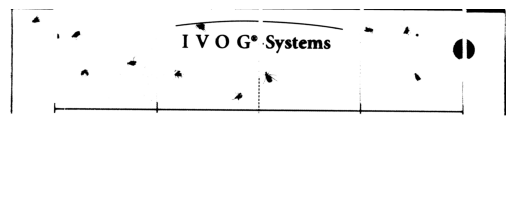

In [41]:
show(create_binary_mask(cropped_image_wo_grid))

19 bounding boxes found.


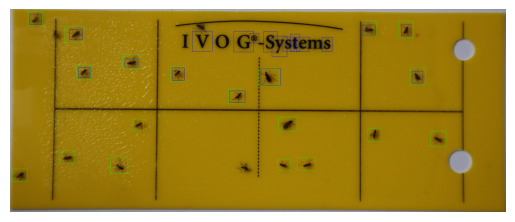

In [42]:
rectangles= get_list_of_rectangles(cropped_image_wo_grid, min_area, max_area, scale = 1.5, max_ratio = 2)

image_labels = draw_bounding_boxes(image_labels, rectangles)
show(image_labels)

In [ ]:


rectangles = [(x, y, x + w, y + h) for (x, y, w, h) in rectangles]
cropped_yolo_rectangles = [(x, y, x + w, y + h) for (x, y, w, h) in cropped_yolo_rectangles]
evaluate_detections(rectangles, cropped_yolo_rectangles)




In [57]:
image_files.index("TRIAVA_0058.jpg")


813

In [46]:
len(image_files)

848

In [52]:
image_files.index("LIRIBO_0193.jpg")

774